<a href="https://colab.research.google.com/github/duwi27sulis/Peramalan-LSTM_75-25/blob/main/Revnb_75_25_Update_H1_T6_Fix_LSTM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install optuna

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 380.1/380.1 kB 5.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 233.0/233.0 kB 13.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.6/78.6 kB 5.3 MB/s eta 0:00:00


In [2]:
# Package
import warnings
warnings.filterwarnings('ignore')
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
import optuna
from optuna.visualization.matplotlib import plot_optimization_history, plot_param_importances
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.optimizers import Adam, RMSprop, SGD

In [3]:
# Fix random seed for reproducibility
tf.random.set_seed(10)
plt.rcParams['figure.figsize'] = (12,6)

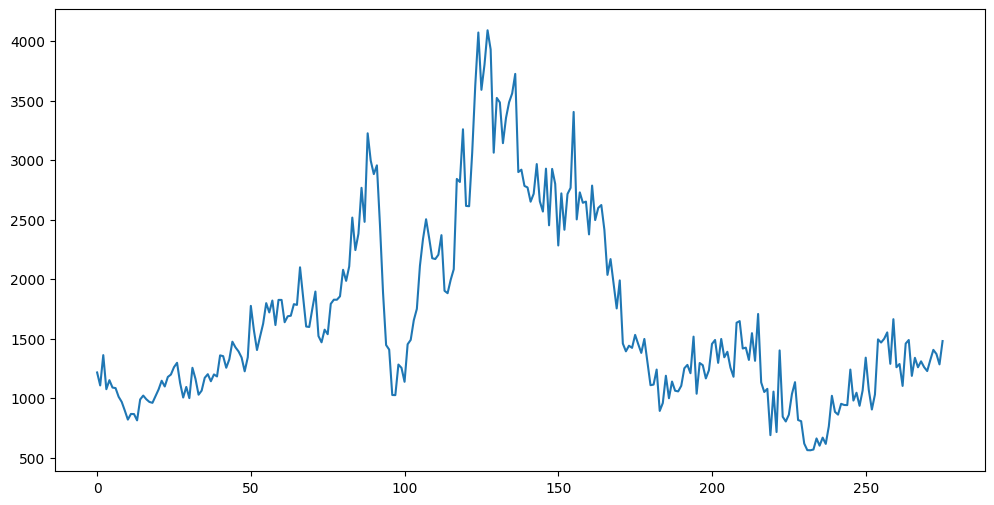

In [4]:
# Input Data
url = "https://raw.githubusercontent.com/duwi27sulis/Analisis_Data_LSTM/main/Ekspor-Migas-2001-2023.csv"
df = pd.read_csv(url, sep=",")
df['Tanggal'] = pd.to_datetime(df.Tanggal)
dataframe = pd.read_csv(url, usecols=[1], engine='python')
dataset = dataframe.values.astype('float32')
plt.plot(dataset)

In [5]:
# Pembagian data
#train_size = int(len(dataset)*0.75)
train_size = 207
test_size = len(dataset) - train_size
train, test = dataset[0:train_size,:], dataset[train_size:len(dataset),:]

In [6]:
time_steps = 6
last_row_train = train[-time_steps:]
test = np.concatenate([last_row_train, test], axis=0)

In [7]:
ytest = test
ytrain = train

In [8]:
# Normalisasi Data
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit(dataset)

train = scaled_data.transform(train)
test = scaled_data.transform(test)

In [9]:
# Fungsi untuk membuat dataset
def create_dataset (X, y, time_steps = time_steps):
    Xs, ys = [], []
    for i in range(len(X)-time_steps):
        v = X[i:i+time_steps, :]
        Xs.append(v)
        ys.append(y[i+time_steps])
    return np.array(Xs), np.array(ys)

In [10]:
X_test, y_test = create_dataset(test, test)
X_train, y_train = create_dataset(train, train)
print('X_train.shape: ', X_train.shape)
print('y_train.shape: ', y_train.shape)
print('X_test.shape: ', X_test.shape)
print('y_test.shape: ', y_test.shape)

X_train.shape:  (201, 6, 1)
y_train.shape:  (201, 1)
X_test.shape:  (69, 6, 1)
y_test.shape:  (69, 1)


In [11]:
# Time series cross-validation
tscv = TimeSeriesSplit(n_splits=5)

In [12]:
# Define early stopping
from keras.callbacks import EarlyStopping
early_stopping = EarlyStopping(monitor='loss', patience=20)

In [13]:
def objective(trial):
    # Define the search space
    lstm_units = trial.suggest_categorical('lstm_units', [32, 64, 128])
    dropout_rate = trial.suggest_categorical('dropout_rate', [0.1, 0.2, 0.3, 0.4, 0.5])
    learning_rate = trial.suggest_categorical('learning_rate', [1e-3, 1e-2, 1e-1])
    batch_size = trial.suggest_categorical('batch_size', [32, 64, 128])
    epochs = trial.suggest_int('epochs', 50, 200, 50)
    optimizer_name = trial.suggest_categorical('optimizer', ['Adam', 'RMSprop', 'SGD'])

    # Cross-validation scores
    cv_scores = []

    for fold_index, (train_index, val_index) in enumerate(tscv.split(X_train)):
        X_train_fold, X_val_fold = X_train[train_index], X_train[val_index]
        y_train_fold, y_val_fold = y_train[train_index], y_train[val_index]

        # Build the model
        model = Sequential([
            LSTM(units=lstm_units, input_shape=(X_train_fold.shape[1], 1)),
            Dropout(dropout_rate),
            Dense(1)
        ])

        # Select optimizer
        if optimizer_name == 'Adam':
            optimizer = Adam(learning_rate=learning_rate)
        elif optimizer_name == 'RMSprop':
            optimizer = RMSprop(learning_rate=learning_rate)
        else:
            optimizer = SGD(learning_rate=learning_rate)

        model.compile(optimizer=optimizer, loss='mse')

        # Fit the model
        history = model.fit(X_train_fold, y_train_fold,
                            validation_data=(X_val_fold, y_val_fold),
                            epochs=epochs,
                            batch_size=batch_size,
                            callbacks=[early_stopping],
                            verbose=0)

        # Evaluate the model
        val_pred = model.predict(X_val_fold)
        mse = mean_squared_error(y_val_fold, val_pred)
        cv_scores.append(mse)

        # Print MSE for each fold
        print(f"Fold {fold_index + 1}: MSE = {mse:.4f}")

    # Print average MSE across all folds
    print(f"Average MSE: {np.mean(cv_scores):.4f}")

    return np.mean(cv_scores)

In [14]:
# Create a study object and optimize the objective function
study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=50)

# Print the best parameters
print('Best parameters:', study.best_params)
print('Best value:', study.best_value)

[I 2024-08-13 23:56:59,281] A new study created in memory with name: no-name-e1ad73ec-d95d-4c9c-9649-3c0e5ccc90c6


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 149ms/step
Fold 1: MSE = 0.0115
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 149ms/step
Fold 2: MSE = 0.0228


1/2 ━━━━━━━━━━━━━━━━━━━━ 0s 166ms/step

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 161ms/step
Fold 3: MSE = 0.0440
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 532ms/step
Fold 4: MSE = 0.0143
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 161ms/step


[I 2024-08-13 23:57:21,802] Trial 0 finished with value: 0.018926996737718582 and parameters: {'lstm_units': 64, 'dropout_rate': 0.4, 'learning_rate': 0.01, 'batch_size': 128, 'epochs': 100, 'optimizer': 'RMSprop'}. Best is trial 0 with value: 0.018926996737718582.


Fold 5: MSE = 0.0021
Average MSE: 0.0189
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 148ms/step
Fold 1: MSE = 0.0844
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 211ms/step
Fold 2: MSE = 0.1885
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 143ms/step
Fold 3: MSE = 0.3886
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 151ms/step
Fold 4: MSE = 0.2363
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 149ms/step


[I 2024-08-13 23:57:35,759] Trial 1 finished with value: 0.18273991346359253 and parameters: {'lstm_units': 64, 'dropout_rate': 0.3, 'learning_rate': 0.001, 'batch_size': 128, 'epochs': 50, 'optimizer': 'SGD'}. Best is trial 0 with value: 0.018926996737718582.


Fold 5: MSE = 0.0160
Average MSE: 0.1827
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 148ms/step
Fold 1: MSE = 0.0036
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 162ms/step
Fold 2: MSE = 0.1318
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 152ms/step
Fold 3: MSE = 0.1201
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 142ms/step
Fold 4: MSE = 0.5825
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 241ms/step


[I 2024-08-13 23:57:54,712] Trial 2 finished with value: 0.21988525986671448 and parameters: {'lstm_units': 64, 'dropout_rate': 0.3, 'learning_rate': 0.1, 'batch_size': 128, 'epochs': 100, 'optimizer': 'RMSprop'}. Best is trial 0 with value: 0.018926996737718582.


Fold 5: MSE = 0.2615
Average MSE: 0.2199
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 152ms/step
Fold 1: MSE = 0.0238
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 156ms/step
Fold 2: MSE = 0.0308
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 233ms/step
Fold 3: MSE = 0.0279
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 156ms/step
Fold 4: MSE = 0.0350
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 174ms/step


[I 2024-08-13 23:58:17,914] Trial 3 finished with value: 0.023977719247341156 and parameters: {'lstm_units': 128, 'dropout_rate': 0.1, 'learning_rate': 0.01, 'batch_size': 32, 'epochs': 100, 'optimizer': 'RMSprop'}. Best is trial 0 with value: 0.018926996737718582.


Fold 5: MSE = 0.0024
Average MSE: 0.0240
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 148ms/step
Fold 1: MSE = 0.0376
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 158ms/step
Fold 2: MSE = 0.0820
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 167ms/step
Fold 3: MSE = 0.1832
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 152ms/step
Fold 4: MSE = 0.0264
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 152ms/step


[I 2024-08-13 23:58:33,219] Trial 4 finished with value: 0.07038182020187378 and parameters: {'lstm_units': 64, 'dropout_rate': 0.1, 'learning_rate': 0.01, 'batch_size': 64, 'epochs': 100, 'optimizer': 'SGD'}. Best is trial 0 with value: 0.018926996737718582.


Fold 5: MSE = 0.0226
Average MSE: 0.0704
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step
Fold 1: MSE = 0.0171
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 149ms/step
Fold 2: MSE = 0.0251
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 218ms/step
Fold 3: MSE = 0.0174
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 145ms/step
Fold 4: MSE = 0.0178
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 894ms/step


[I 2024-08-13 23:58:52,629] Trial 5 finished with value: 0.015872184187173843 and parameters: {'lstm_units': 64, 'dropout_rate': 0.4, 'learning_rate': 0.001, 'batch_size': 32, 'epochs': 150, 'optimizer': 'RMSprop'}. Best is trial 5 with value: 0.015872184187173843.


Fold 5: MSE = 0.0019
Average MSE: 0.0159
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 156ms/step
Fold 1: MSE = 0.0383
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 153ms/step
Fold 2: MSE = 0.1135
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 161ms/step
Fold 3: MSE = 0.3118
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 159ms/step
Fold 4: MSE = 0.0421
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 148ms/step


[I 2024-08-13 23:59:07,543] Trial 6 finished with value: 0.10436415672302246 and parameters: {'lstm_units': 32, 'dropout_rate': 0.5, 'learning_rate': 0.01, 'batch_size': 128, 'epochs': 50, 'optimizer': 'SGD'}. Best is trial 5 with value: 0.015872184187173843.


Fold 5: MSE = 0.0161
Average MSE: 0.1044
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step
Fold 1: MSE = 0.8301
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 143ms/step
Fold 2: MSE = 2.9334
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step
Fold 3: MSE = 0.8792
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 146ms/step
Fold 4: MSE = 0.0889
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 154ms/step


[I 2024-08-13 23:59:27,480] Trial 7 finished with value: 0.9528763890266418 and parameters: {'lstm_units': 64, 'dropout_rate': 0.1, 'learning_rate': 0.1, 'batch_size': 128, 'epochs': 200, 'optimizer': 'Adam'}. Best is trial 5 with value: 0.015872184187173843.


Fold 5: MSE = 0.0328
Average MSE: 0.9529
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 158ms/step
Fold 1: MSE = 0.0210
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 237ms/step
Fold 2: MSE = 0.0573
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 151ms/step
Fold 3: MSE = 0.1775
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 157ms/step
Fold 4: MSE = 0.0093
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 152ms/step


[I 2024-08-13 23:59:45,538] Trial 8 finished with value: 0.05563140660524368 and parameters: {'lstm_units': 128, 'dropout_rate': 0.5, 'learning_rate': 0.1, 'batch_size': 128, 'epochs': 100, 'optimizer': 'SGD'}. Best is trial 5 with value: 0.015872184187173843.


Fold 5: MSE = 0.0130
Average MSE: 0.0556
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 230ms/step
Fold 1: MSE = 0.0338
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 145ms/step
Fold 2: MSE = 0.0644
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step
Fold 3: MSE = 0.2155
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 151ms/step
Fold 4: MSE = 0.0090
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 218ms/step


[I 2024-08-13 23:59:59,614] Trial 9 finished with value: 0.06652010977268219 and parameters: {'lstm_units': 32, 'dropout_rate': 0.3, 'learning_rate': 0.1, 'batch_size': 128, 'epochs': 150, 'optimizer': 'SGD'}. Best is trial 5 with value: 0.015872184187173843.


Fold 5: MSE = 0.0100
Average MSE: 0.0665
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 149ms/step
Fold 1: MSE = 0.0203
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 148ms/step
Fold 2: MSE = 0.0249
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 145ms/step
Fold 3: MSE = 0.0413
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 151ms/step
Fold 4: MSE = 0.0077
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


[I 2024-08-14 00:00:22,372] Trial 10 finished with value: 0.01962919533252716 and parameters: {'lstm_units': 32, 'dropout_rate': 0.4, 'learning_rate': 0.001, 'batch_size': 32, 'epochs': 200, 'optimizer': 'Adam'}. Best is trial 5 with value: 0.015872184187173843.


Fold 5: MSE = 0.0039
Average MSE: 0.0196
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 229ms/step
Fold 1: MSE = 0.0152
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 162ms/step
Fold 2: MSE = 0.0255
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 165ms/step
Fold 3: MSE = 0.0182
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 148ms/step
Fold 4: MSE = 0.0121
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step


[I 2024-08-14 00:00:42,539] Trial 11 finished with value: 0.014645692892372608 and parameters: {'lstm_units': 64, 'dropout_rate': 0.4, 'learning_rate': 0.001, 'batch_size': 32, 'epochs': 150, 'optimizer': 'RMSprop'}. Best is trial 11 with value: 0.014645692892372608.


Fold 5: MSE = 0.0023
Average MSE: 0.0146
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 174ms/step
Fold 1: MSE = 0.0200
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step
Fold 2: MSE = 0.0314
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 151ms/step
Fold 3: MSE = 0.0173
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 150ms/step
Fold 4: MSE = 0.0162
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 159ms/step


[I 2024-08-14 00:01:01,305] Trial 12 finished with value: 0.017345821484923363 and parameters: {'lstm_units': 64, 'dropout_rate': 0.2, 'learning_rate': 0.001, 'batch_size': 32, 'epochs': 150, 'optimizer': 'RMSprop'}. Best is trial 11 with value: 0.014645692892372608.


Fold 5: MSE = 0.0018
Average MSE: 0.0173
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 217ms/step
Fold 1: MSE = 0.0202
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 149ms/step
Fold 2: MSE = 0.0264
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 171ms/step
Fold 3: MSE = 0.0202
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 237ms/step
Fold 4: MSE = 0.0147
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 154ms/step


[I 2024-08-14 00:01:22,389] Trial 13 finished with value: 0.0166977159678936 and parameters: {'lstm_units': 64, 'dropout_rate': 0.4, 'learning_rate': 0.001, 'batch_size': 32, 'epochs': 150, 'optimizer': 'RMSprop'}. Best is trial 11 with value: 0.014645692892372608.


Fold 5: MSE = 0.0019
Average MSE: 0.0167
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 149ms/step
Fold 1: MSE = 0.0126
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 221ms/step
Fold 2: MSE = 0.0248
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 151ms/step
Fold 3: MSE = 0.0211
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 167ms/step
Fold 4: MSE = 0.0137
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 144ms/step


[I 2024-08-14 00:01:42,132] Trial 14 finished with value: 0.014821985736489296 and parameters: {'lstm_units': 64, 'dropout_rate': 0.4, 'learning_rate': 0.001, 'batch_size': 32, 'epochs': 200, 'optimizer': 'RMSprop'}. Best is trial 11 with value: 0.014645692892372608.


Fold 5: MSE = 0.0019
Average MSE: 0.0148
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 149ms/step
Fold 1: MSE = 0.0107
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 146ms/step
Fold 2: MSE = 0.0299
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 163ms/step
Fold 3: MSE = 0.0284
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 158ms/step
Fold 4: MSE = 0.0179
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 169ms/step


[I 2024-08-14 00:02:04,912] Trial 15 finished with value: 0.017897436395287514 and parameters: {'lstm_units': 128, 'dropout_rate': 0.4, 'learning_rate': 0.001, 'batch_size': 64, 'epochs': 200, 'optimizer': 'RMSprop'}. Best is trial 11 with value: 0.014645692892372608.


Fold 5: MSE = 0.0026
Average MSE: 0.0179
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 370ms/step
Fold 1: MSE = 0.0217
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 158ms/step
Fold 2: MSE = 0.0269
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 165ms/step
Fold 3: MSE = 0.0167
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 226ms/step
Fold 4: MSE = 0.0134
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 151ms/step


[I 2024-08-14 00:02:29,191] Trial 16 finished with value: 0.01609494723379612 and parameters: {'lstm_units': 64, 'dropout_rate': 0.2, 'learning_rate': 0.001, 'batch_size': 32, 'epochs': 200, 'optimizer': 'RMSprop'}. Best is trial 11 with value: 0.014645692892372608.


Fold 5: MSE = 0.0018
Average MSE: 0.0161
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 166ms/step
Fold 1: MSE = 0.0190
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 234ms/step
Fold 2: MSE = 0.0295
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 152ms/step
Fold 3: MSE = 0.0239
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 145ms/step
Fold 4: MSE = 0.0079
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 148ms/step


[I 2024-08-14 00:02:49,212] Trial 17 finished with value: 0.01667567528784275 and parameters: {'lstm_units': 64, 'dropout_rate': 0.4, 'learning_rate': 0.001, 'batch_size': 32, 'epochs': 200, 'optimizer': 'Adam'}. Best is trial 11 with value: 0.014645692892372608.


Fold 5: MSE = 0.0030
Average MSE: 0.0167
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 153ms/step
Fold 1: MSE = 0.0198
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 161ms/step
Fold 2: MSE = 0.0266
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 231ms/step
Fold 3: MSE = 0.0191
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 170ms/step
Fold 4: MSE = 0.0200
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 153ms/step


[I 2024-08-14 00:03:14,381] Trial 18 finished with value: 0.017474465072155 and parameters: {'lstm_units': 128, 'dropout_rate': 0.4, 'learning_rate': 0.001, 'batch_size': 32, 'epochs': 150, 'optimizer': 'RMSprop'}. Best is trial 11 with value: 0.014645692892372608.


Fold 5: MSE = 0.0019
Average MSE: 0.0175
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 153ms/step
Fold 1: MSE = 0.0116
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step
Fold 2: MSE = 0.0385
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 155ms/step
Fold 3: MSE = 0.0499
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 152ms/step
Fold 4: MSE = 0.0093
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 154ms/step


[I 2024-08-14 00:03:35,914] Trial 19 finished with value: 0.022518426179885864 and parameters: {'lstm_units': 32, 'dropout_rate': 0.4, 'learning_rate': 0.001, 'batch_size': 64, 'epochs': 200, 'optimizer': 'RMSprop'}. Best is trial 11 with value: 0.014645692892372608.


Fold 5: MSE = 0.0032
Average MSE: 0.0225
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 150ms/step
Fold 1: MSE = 0.0098
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 165ms/step
Fold 2: MSE = 0.0243
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 173ms/step
Fold 3: MSE = 0.0235
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 148ms/step
Fold 4: MSE = 0.0095
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 148ms/step


[I 2024-08-14 00:03:57,559] Trial 20 finished with value: 0.013927129097282887 and parameters: {'lstm_units': 64, 'dropout_rate': 0.2, 'learning_rate': 0.001, 'batch_size': 32, 'epochs': 150, 'optimizer': 'Adam'}. Best is trial 20 with value: 0.013927129097282887.


Fold 5: MSE = 0.0025
Average MSE: 0.0139
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 152ms/step
Fold 1: MSE = 0.0204
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 149ms/step
Fold 2: MSE = 0.0252
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step
Fold 3: MSE = 0.0341
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 156ms/step
Fold 4: MSE = 0.0108
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 148ms/step


[I 2024-08-14 00:04:18,146] Trial 21 finished with value: 0.018645789474248886 and parameters: {'lstm_units': 64, 'dropout_rate': 0.2, 'learning_rate': 0.001, 'batch_size': 32, 'epochs': 150, 'optimizer': 'Adam'}. Best is trial 20 with value: 0.013927129097282887.


Fold 5: MSE = 0.0027
Average MSE: 0.0186
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 151ms/step
Fold 1: MSE = 0.0200
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 165ms/step
Fold 2: MSE = 0.0255
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 152ms/step
Fold 3: MSE = 0.0265
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 153ms/step
Fold 4: MSE = 0.0103
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 172ms/step


[I 2024-08-14 00:04:42,383] Trial 22 finished with value: 0.01694539003074169 and parameters: {'lstm_units': 64, 'dropout_rate': 0.2, 'learning_rate': 0.001, 'batch_size': 32, 'epochs': 150, 'optimizer': 'Adam'}. Best is trial 20 with value: 0.013927129097282887.


Fold 5: MSE = 0.0024
Average MSE: 0.0169
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 236ms/step
Fold 1: MSE = 0.0164
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 155ms/step
Fold 2: MSE = 0.0271
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 151ms/step
Fold 3: MSE = 0.0276
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 172ms/step
Fold 4: MSE = 0.0099
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 150ms/step


[I 2024-08-14 00:05:05,005] Trial 23 finished with value: 0.01689954660832882 and parameters: {'lstm_units': 64, 'dropout_rate': 0.2, 'learning_rate': 0.001, 'batch_size': 32, 'epochs': 150, 'optimizer': 'Adam'}. Best is trial 20 with value: 0.013927129097282887.


Fold 5: MSE = 0.0036
Average MSE: 0.0169
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 150ms/step
Fold 1: MSE = 0.0227
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 153ms/step
Fold 2: MSE = 0.0263
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 161ms/step
Fold 3: MSE = 0.0243
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 153ms/step
Fold 4: MSE = 0.0074
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 167ms/step


[I 2024-08-14 00:05:26,904] Trial 24 finished with value: 0.01680927164852619 and parameters: {'lstm_units': 64, 'dropout_rate': 0.5, 'learning_rate': 0.001, 'batch_size': 32, 'epochs': 200, 'optimizer': 'Adam'}. Best is trial 20 with value: 0.013927129097282887.


Fold 5: MSE = 0.0033
Average MSE: 0.0168
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 149ms/step
Fold 1: MSE = 0.0191
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 167ms/step
Fold 2: MSE = 0.0274
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 149ms/step
Fold 3: MSE = 0.0198
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 169ms/step
Fold 4: MSE = 0.0142
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 157ms/step


[I 2024-08-14 00:05:47,006] Trial 25 finished with value: 0.016490189358592033 and parameters: {'lstm_units': 64, 'dropout_rate': 0.2, 'learning_rate': 0.001, 'batch_size': 32, 'epochs': 150, 'optimizer': 'RMSprop'}. Best is trial 20 with value: 0.013927129097282887.


Fold 5: MSE = 0.0019
Average MSE: 0.0165
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 153ms/step
Fold 1: MSE = 0.0055
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 162ms/step
Fold 2: MSE = 0.0345
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 148ms/step
Fold 3: MSE = 0.0467
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 152ms/step
Fold 4: MSE = 0.0134
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 163ms/step


[I 2024-08-14 00:06:10,927] Trial 26 finished with value: 0.020817425101995468 and parameters: {'lstm_units': 64, 'dropout_rate': 0.4, 'learning_rate': 0.001, 'batch_size': 64, 'epochs': 200, 'optimizer': 'Adam'}. Best is trial 20 with value: 0.013927129097282887.


Fold 5: MSE = 0.0041
Average MSE: 0.0208
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 230ms/step
Fold 1: MSE = 0.0226
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 158ms/step
Fold 2: MSE = 0.0267
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 158ms/step
Fold 3: MSE = 0.0198
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 155ms/step
Fold 4: MSE = 0.0113
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 156ms/step


[I 2024-08-14 00:06:32,124] Trial 27 finished with value: 0.016477610915899277 and parameters: {'lstm_units': 64, 'dropout_rate': 0.4, 'learning_rate': 0.001, 'batch_size': 32, 'epochs': 150, 'optimizer': 'RMSprop'}. Best is trial 20 with value: 0.013927129097282887.


Fold 5: MSE = 0.0019
Average MSE: 0.0165
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 168ms/step
Fold 1: MSE = 0.0095
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 229ms/step
Fold 2: MSE = 0.0284
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 160ms/step
Fold 3: MSE = 0.2565
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 161ms/step
Fold 4: MSE = 0.0139
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 148ms/step


[I 2024-08-14 00:06:57,761] Trial 28 finished with value: 0.0639866441488266 and parameters: {'lstm_units': 128, 'dropout_rate': 0.2, 'learning_rate': 0.1, 'batch_size': 32, 'epochs': 100, 'optimizer': 'Adam'}. Best is trial 20 with value: 0.013927129097282887.


Fold 5: MSE = 0.0116
Average MSE: 0.0640
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 153ms/step
Fold 1: MSE = 0.0309
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 148ms/step
Fold 2: MSE = 0.0270
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 150ms/step
Fold 3: MSE = 0.0124
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 185ms/step
Fold 4: MSE = 0.0327
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 145ms/step


[I 2024-08-14 00:07:16,447] Trial 29 finished with value: 0.020933223888278008 and parameters: {'lstm_units': 32, 'dropout_rate': 0.4, 'learning_rate': 0.01, 'batch_size': 32, 'epochs': 50, 'optimizer': 'RMSprop'}. Best is trial 20 with value: 0.013927129097282887.


Fold 5: MSE = 0.0016
Average MSE: 0.0209
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 226ms/step
Fold 1: MSE = 0.0142
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 156ms/step
Fold 2: MSE = 0.0234
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 154ms/step
Fold 3: MSE = 0.0133
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 162ms/step
Fold 4: MSE = 0.0309
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 149ms/step


[I 2024-08-14 00:07:35,130] Trial 30 finished with value: 0.017533117905259132 and parameters: {'lstm_units': 64, 'dropout_rate': 0.3, 'learning_rate': 0.01, 'batch_size': 64, 'epochs': 200, 'optimizer': 'RMSprop'}. Best is trial 20 with value: 0.013927129097282887.


Fold 5: MSE = 0.0059
Average MSE: 0.0175
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 148ms/step
Fold 1: MSE = 0.0202
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 160ms/step
Fold 2: MSE = 0.0249
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 249ms/step
Fold 3: MSE = 0.0220
2/2 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
Fold 4: MSE = 0.0167
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 259ms/step


[I 2024-08-14 00:07:57,209] Trial 31 finished with value: 0.017139125615358353 and parameters: {'lstm_units': 64, 'dropout_rate': 0.4, 'learning_rate': 0.001, 'batch_size': 32, 'epochs': 150, 'optimizer': 'RMSprop'}. Best is trial 20 with value: 0.013927129097282887.


Fold 5: MSE = 0.0020
Average MSE: 0.0171
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 160ms/step
Fold 1: MSE = 0.0217
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 173ms/step
Fold 2: MSE = 0.0282
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 156ms/step
Fold 3: MSE = 0.0178
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 180ms/step
Fold 4: MSE = 0.0142
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 158ms/step


[I 2024-08-14 00:08:18,641] Trial 32 finished with value: 0.016778526827692986 and parameters: {'lstm_units': 64, 'dropout_rate': 0.4, 'learning_rate': 0.001, 'batch_size': 32, 'epochs': 150, 'optimizer': 'RMSprop'}. Best is trial 20 with value: 0.013927129097282887.


Fold 5: MSE = 0.0020
Average MSE: 0.0168
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 163ms/step
Fold 1: MSE = 0.0132
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 151ms/step
Fold 2: MSE = 0.0287
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 150ms/step
Fold 3: MSE = 0.0319
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 153ms/step
Fold 4: MSE = 0.0125
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 157ms/step


[I 2024-08-14 00:08:39,027] Trial 33 finished with value: 0.017621077597141266 and parameters: {'lstm_units': 64, 'dropout_rate': 0.4, 'learning_rate': 0.001, 'batch_size': 32, 'epochs': 150, 'optimizer': 'RMSprop'}. Best is trial 20 with value: 0.013927129097282887.


Fold 5: MSE = 0.0018
Average MSE: 0.0176
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 150ms/step
Fold 1: MSE = 0.0218
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 162ms/step
Fold 2: MSE = 0.0255
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 221ms/step
Fold 3: MSE = 0.0245
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 150ms/step
Fold 4: MSE = 0.0216
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 153ms/step


[I 2024-08-14 00:08:58,251] Trial 34 finished with value: 0.01905765011906624 and parameters: {'lstm_units': 64, 'dropout_rate': 0.4, 'learning_rate': 0.001, 'batch_size': 32, 'epochs': 100, 'optimizer': 'RMSprop'}. Best is trial 20 with value: 0.013927129097282887.


Fold 5: MSE = 0.0018
Average MSE: 0.0191
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 230ms/step
Fold 1: MSE = 0.0177
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 153ms/step
Fold 2: MSE = 0.0376
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 155ms/step
Fold 3: MSE = 0.0191
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 145ms/step
Fold 4: MSE = 0.0149
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 156ms/step


[I 2024-08-14 00:09:18,562] Trial 35 finished with value: 0.018240444362163544 and parameters: {'lstm_units': 64, 'dropout_rate': 0.1, 'learning_rate': 0.001, 'batch_size': 32, 'epochs': 100, 'optimizer': 'RMSprop'}. Best is trial 20 with value: 0.013927129097282887.


Fold 5: MSE = 0.0019
Average MSE: 0.0182
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 168ms/step
Fold 1: MSE = 0.0232
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 163ms/step
Fold 2: MSE = 0.0179
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 176ms/step
Fold 3: MSE = 0.0398
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 155ms/step
Fold 4: MSE = 0.0299
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 162ms/step


[I 2024-08-14 00:09:37,536] Trial 36 finished with value: 0.022479142993688583 and parameters: {'lstm_units': 64, 'dropout_rate': 0.3, 'learning_rate': 0.01, 'batch_size': 32, 'epochs': 150, 'optimizer': 'RMSprop'}. Best is trial 20 with value: 0.013927129097282887.


Fold 5: MSE = 0.0017
Average MSE: 0.0225
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 222ms/step
Fold 1: MSE = 0.1017
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 157ms/step
Fold 2: MSE = 0.2226
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 160ms/step
Fold 3: MSE = 0.4671
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 149ms/step
Fold 4: MSE = 0.1973
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 161ms/step


[I 2024-08-14 00:09:52,435] Trial 37 finished with value: 0.20146052539348602 and parameters: {'lstm_units': 64, 'dropout_rate': 0.5, 'learning_rate': 0.001, 'batch_size': 128, 'epochs': 50, 'optimizer': 'SGD'}. Best is trial 20 with value: 0.013927129097282887.


Fold 5: MSE = 0.0185
Average MSE: 0.2015
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 171ms/step
Fold 1: MSE = 0.0263
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 170ms/step
Fold 2: MSE = 0.0637
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 159ms/step
Fold 3: MSE = 0.0784
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 162ms/step
Fold 4: MSE = 0.0112
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 162ms/step


[I 2024-08-14 00:10:18,598] Trial 38 finished with value: 0.036282822489738464 and parameters: {'lstm_units': 128, 'dropout_rate': 0.1, 'learning_rate': 0.1, 'batch_size': 32, 'epochs': 100, 'optimizer': 'SGD'}. Best is trial 20 with value: 0.013927129097282887.


Fold 5: MSE = 0.0017
Average MSE: 0.0363
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 158ms/step
Fold 1: MSE = 0.0182
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 161ms/step
Fold 2: MSE = 0.0363
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 158ms/step
Fold 3: MSE = 0.0677
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 168ms/step
Fold 4: MSE = 0.0143
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 164ms/step


[I 2024-08-14 00:10:39,758] Trial 39 finished with value: 0.02833470143377781 and parameters: {'lstm_units': 64, 'dropout_rate': 0.4, 'learning_rate': 0.001, 'batch_size': 128, 'epochs': 200, 'optimizer': 'RMSprop'}. Best is trial 20 with value: 0.013927129097282887.


Fold 5: MSE = 0.0052
Average MSE: 0.0283
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 154ms/step
Fold 1: MSE = 0.0154
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 156ms/step
Fold 2: MSE = 0.0217
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 154ms/step
Fold 3: MSE = 0.0192
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 154ms/step
Fold 4: MSE = 0.0065
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 152ms/step


[I 2024-08-14 00:11:01,899] Trial 40 finished with value: 0.012928281910717487 and parameters: {'lstm_units': 32, 'dropout_rate': 0.3, 'learning_rate': 0.01, 'batch_size': 32, 'epochs': 150, 'optimizer': 'Adam'}. Best is trial 40 with value: 0.012928281910717487.


Fold 5: MSE = 0.0018
Average MSE: 0.0129
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 157ms/step
Fold 1: MSE = 0.0187
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 149ms/step
Fold 2: MSE = 0.0210
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 160ms/step
Fold 3: MSE = 0.0171
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 150ms/step
Fold 4: MSE = 0.0079
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 148ms/step


[I 2024-08-14 00:11:21,487] Trial 41 finished with value: 0.01336660422384739 and parameters: {'lstm_units': 32, 'dropout_rate': 0.3, 'learning_rate': 0.01, 'batch_size': 32, 'epochs': 150, 'optimizer': 'Adam'}. Best is trial 40 with value: 0.012928281910717487.


Fold 5: MSE = 0.0022
Average MSE: 0.0134
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 151ms/step
Fold 1: MSE = 0.0154
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 150ms/step
Fold 2: MSE = 0.0198
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 154ms/step
Fold 3: MSE = 0.0137
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step
Fold 4: MSE = 0.0062
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 152ms/step


[I 2024-08-14 00:11:43,054] Trial 42 finished with value: 0.011357149109244347 and parameters: {'lstm_units': 32, 'dropout_rate': 0.3, 'learning_rate': 0.01, 'batch_size': 32, 'epochs': 150, 'optimizer': 'Adam'}. Best is trial 42 with value: 0.011357149109244347.


Fold 5: MSE = 0.0016
Average MSE: 0.0114
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 160ms/step
Fold 1: MSE = 0.0151
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 150ms/step
Fold 2: MSE = 0.0178
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 162ms/step
Fold 3: MSE = 0.0180
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 154ms/step
Fold 4: MSE = 0.0092
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 160ms/step


[I 2024-08-14 00:12:04,252] Trial 43 finished with value: 0.012371267192065716 and parameters: {'lstm_units': 32, 'dropout_rate': 0.3, 'learning_rate': 0.01, 'batch_size': 32, 'epochs': 150, 'optimizer': 'Adam'}. Best is trial 42 with value: 0.011357149109244347.


Fold 5: MSE = 0.0017
Average MSE: 0.0124
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 150ms/step
Fold 1: MSE = 0.0172
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 149ms/step
Fold 2: MSE = 0.0189
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 199ms/step
Fold 3: MSE = 0.0134
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 176ms/step
Fold 4: MSE = 0.0076
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 158ms/step


[I 2024-08-14 00:12:31,709] Trial 44 finished with value: 0.01183827593922615 and parameters: {'lstm_units': 32, 'dropout_rate': 0.3, 'learning_rate': 0.01, 'batch_size': 32, 'epochs': 150, 'optimizer': 'Adam'}. Best is trial 42 with value: 0.011357149109244347.


Fold 5: MSE = 0.0021
Average MSE: 0.0118
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 162ms/step
Fold 1: MSE = 0.0204
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 171ms/step
Fold 2: MSE = 0.0191
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 157ms/step
Fold 3: MSE = 0.0135
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 159ms/step
Fold 4: MSE = 0.0078
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 169ms/step


[I 2024-08-14 00:12:53,498] Trial 45 finished with value: 0.012542697601020336 and parameters: {'lstm_units': 32, 'dropout_rate': 0.3, 'learning_rate': 0.01, 'batch_size': 32, 'epochs': 150, 'optimizer': 'Adam'}. Best is trial 42 with value: 0.011357149109244347.


Fold 5: MSE = 0.0020
Average MSE: 0.0125
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 167ms/step
Fold 1: MSE = 0.0152
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 172ms/step
Fold 2: MSE = 0.0170
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 148ms/step
Fold 3: MSE = 0.0155
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 153ms/step
Fold 4: MSE = 0.0120
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 155ms/step


[I 2024-08-14 00:13:15,753] Trial 46 finished with value: 0.012414740398526192 and parameters: {'lstm_units': 32, 'dropout_rate': 0.3, 'learning_rate': 0.01, 'batch_size': 32, 'epochs': 150, 'optimizer': 'Adam'}. Best is trial 42 with value: 0.011357149109244347.


Fold 5: MSE = 0.0024
Average MSE: 0.0124
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 148ms/step
Fold 1: MSE = 0.0114
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 153ms/step
Fold 2: MSE = 0.0201
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 165ms/step
Fold 3: MSE = 0.0394
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 157ms/step
Fold 4: MSE = 0.0071
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 150ms/step


[I 2024-08-14 00:13:35,709] Trial 47 finished with value: 0.01595086231827736 and parameters: {'lstm_units': 32, 'dropout_rate': 0.3, 'learning_rate': 0.01, 'batch_size': 128, 'epochs': 150, 'optimizer': 'Adam'}. Best is trial 42 with value: 0.011357149109244347.


Fold 5: MSE = 0.0017
Average MSE: 0.0160
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 156ms/step
Fold 1: MSE = 0.0124
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step
Fold 2: MSE = 0.0184
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 223ms/step
Fold 3: MSE = 0.0146
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 152ms/step
Fold 4: MSE = 0.0070
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 153ms/step


[I 2024-08-14 00:13:54,869] Trial 48 finished with value: 0.010915395803749561 and parameters: {'lstm_units': 32, 'dropout_rate': 0.3, 'learning_rate': 0.01, 'batch_size': 64, 'epochs': 100, 'optimizer': 'Adam'}. Best is trial 48 with value: 0.010915395803749561.


Fold 5: MSE = 0.0022
Average MSE: 0.0109
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 221ms/step
Fold 1: MSE = 0.0146
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 151ms/step
Fold 2: MSE = 0.0214
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 149ms/step
Fold 3: MSE = 0.0182
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 152ms/step
Fold 4: MSE = 0.0135
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 150ms/step


[I 2024-08-14 00:14:15,594] Trial 49 finished with value: 0.013897797092795372 and parameters: {'lstm_units': 32, 'dropout_rate': 0.3, 'learning_rate': 0.01, 'batch_size': 64, 'epochs': 100, 'optimizer': 'Adam'}. Best is trial 48 with value: 0.010915395803749561.


Fold 5: MSE = 0.0018
Average MSE: 0.0139
Best parameters: {'lstm_units': 32, 'dropout_rate': 0.3, 'learning_rate': 0.01, 'batch_size': 64, 'epochs': 100, 'optimizer': 'Adam'}
Best value: 0.010915395803749561


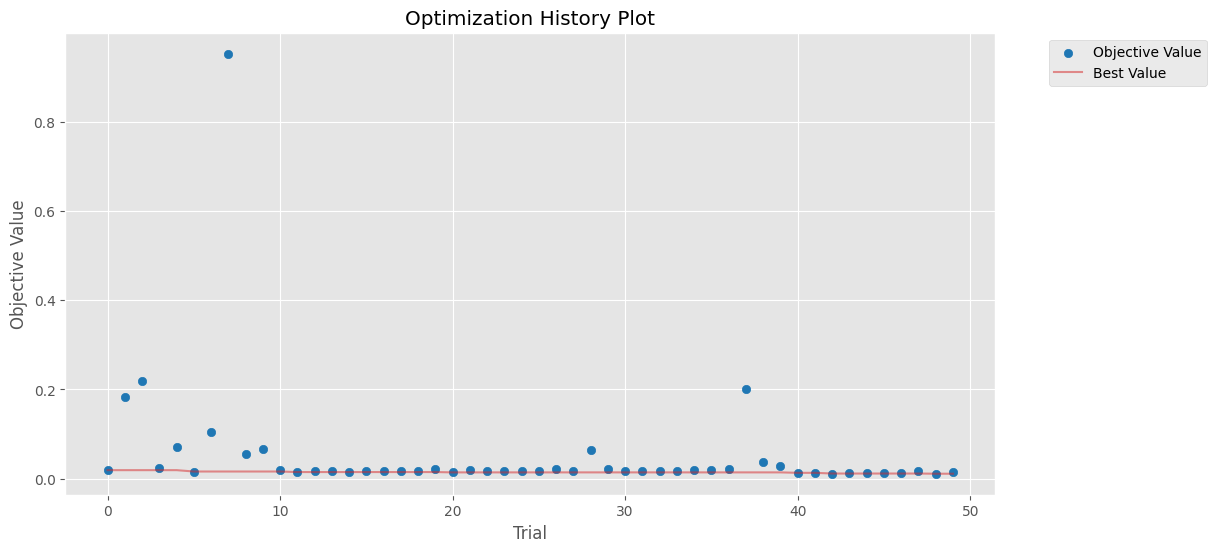

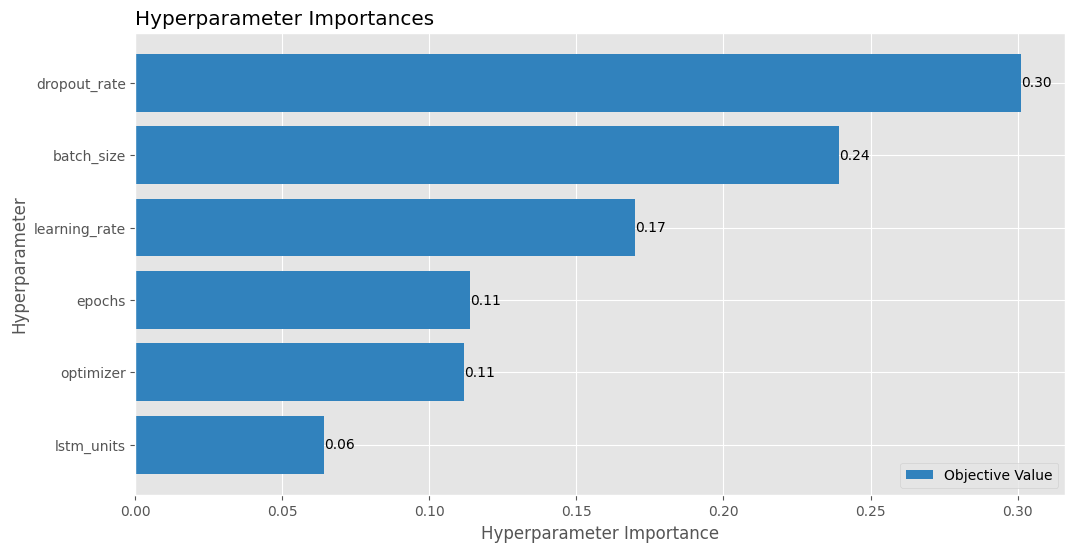

In [15]:
# Plot optimization history and parameter importances
plot_optimization_history(study)
plt.show()
plot_param_importances(study)
plt.show()

In [16]:
# Train final model with best parameters
best_params = study.best_params
model = Sequential([
    LSTM(units=best_params['lstm_units'], input_shape=(X_train.shape[1], 1)),
    Dropout(best_params['dropout_rate']),
    Dense(1)
])

# Select optimizer based on best parameters
if best_params['optimizer'] == 'Adam':
    optimizer = Adam(learning_rate=best_params['learning_rate'])
elif best_params['optimizer'] == 'RMSprop':
    optimizer = RMSprop(learning_rate=best_params['learning_rate'])
else:
    optimizer = SGD(learning_rate=best_params['learning_rate'])

model.compile(optimizer=optimizer, loss='mse')

# Train the model on the full training dataset
history = model.fit(X_train, y_train,
                    validation_split=0.2,
                    epochs=best_params['epochs'],
                    batch_size=best_params['batch_size'],
                    verbose=1)

Epoch 1/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 3s 230ms/step - loss: 0.2402 - val_loss: 0.0048
Epoch 2/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - loss: 0.0358 - val_loss: 0.0741
Epoch 3/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - loss: 0.0536 - val_loss: 0.0119
Epoch 4/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 0.0202 - val_loss: 0.0022
Epoch 5/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 0.0301 - val_loss: 0.0021
Epoch 6/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 0.0272 - val_loss: 0.0056
Epoch 7/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 0.0195 - val_loss: 0.0152
Epoch 8/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 0.0196 - val_loss: 0.0181
Epoch 9/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 0.0186 - val_loss: 0.0089
Epoch 10/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 0.0145 - val_loss: 0.0032
Epoch 11/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 0.0173 - val_loss: 0.0025
Epoch 12/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 0.0118 - val_l

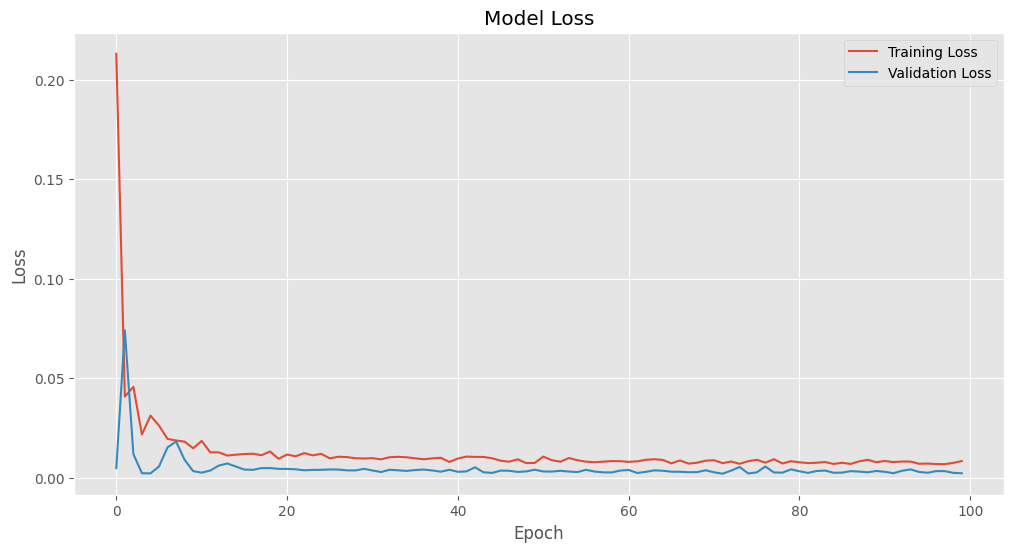

Average Loss: 0.0127


In [17]:
# Fungsi untuk plot training dan validation loss
def plot_loss(history):
    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title('Model Loss')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(loc='upper right')
    plt.show()

plot_loss(history)

average_loss = np.mean(history.history['loss'])
print(f"Average Loss: {average_loss:.4f}")

In [18]:
# Make predictions on the training and testing datasets
train_predictions = model.predict(X_train)
test_predictions = model.predict(X_test)

7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


In [19]:
# Inverse transform predictions and actual values
train_predictions = scaler.inverse_transform(train_predictions)
test_predictions = scaler.inverse_transform(test_predictions)
y_train_actual = scaler.inverse_transform(y_train.reshape(-1, 1))
y_test_actual = scaler.inverse_transform(y_test.reshape(-1, 1))

In [20]:
# Define a function to calculate MAE, MAPE, and RMSE
def evaluate_prediction(predictions, actual, model_name):
    errors = predictions - actual
    mse = np.square(errors).mean()
    rmse = np.sqrt(mse)
    mae = np.abs(errors).mean()
    mape = np.mean(np.abs(errors / actual)) * 100  # Calculate MAPE

    print(model_name + ':')
    print('Mean Absolute Error: {:.3f}'.format(mae))
    print('Root Mean Square Error: {:.3f}'.format(rmse))
    print('Mean Absolute Percentage Error: {:.3f}%'.format(mape))
    print('')

In [21]:
# Evaluasi Model for Training Data
evaluate_prediction(train_predictions, y_train_actual, 'evaluasi model data train')

# Evaluasi Model for Testing Data
evaluate_prediction(test_predictions, y_test_actual, 'evaluasi model data test')

evaluasi model data train:
Mean Absolute Error: 184.047
Root Mean Square Error: 258.029
Mean Absolute Percentage Error: 9.479%

evaluasi model data test:
Mean Absolute Error: 164.221
Root Mean Square Error: 204.641
Mean Absolute Percentage Error: 15.238%



In [22]:
date_train = df['Tanggal'][time_steps:len(y_train_actual) + time_steps]
date_test = df['Tanggal'][-len(y_test_actual):]

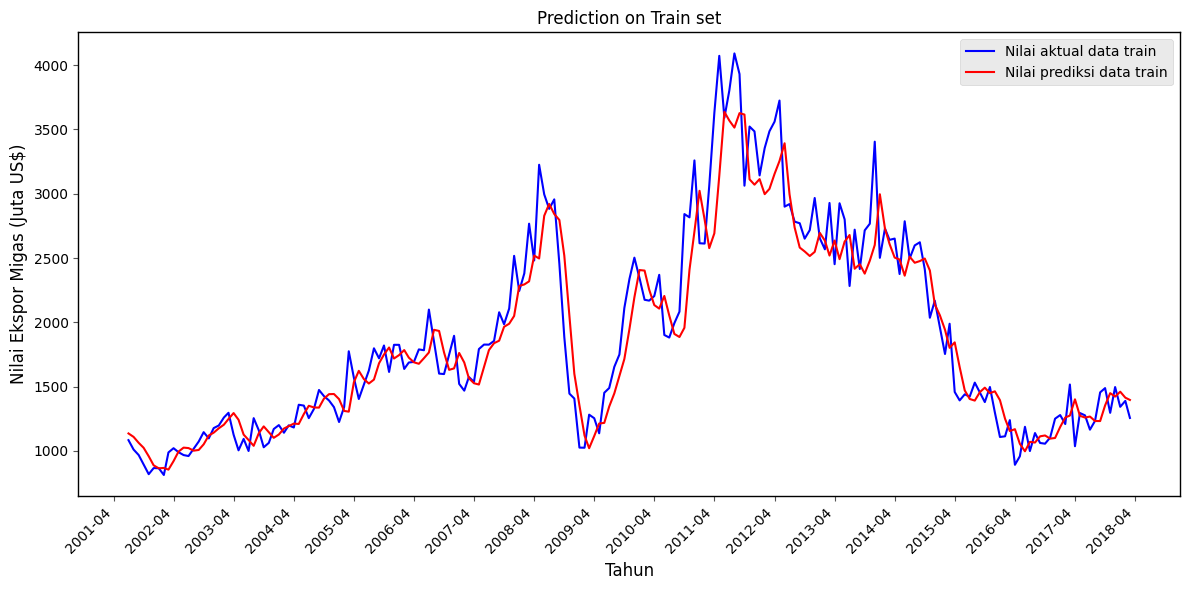

In [23]:
import matplotlib.dates as mdates
# Visualisasi prediksi vs aktual on train data
plt.figure(figsize=(12,6))
plt.title('Prediction on Train set', fontsize=12)
plt.xlabel('Tahun', fontsize=12, color='black')
plt.ylabel('Nilai Ekspor Migas (Juta US$)', fontsize=12, color='black')
plt.plot(date_train, y_train_actual, label='Nilai aktual data train', color='blue')
plt.plot(date_train, train_predictions, label='Nilai prediksi data train', color='red')
plt.legend(fontsize=10)
plt.xticks(rotation=45, ha='right', color='black')
plt.yticks(color='black')

# Mengatur format tanggal
plt.gca().xaxis.set_major_locator(mdates.MonthLocator(interval=12))
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))

# Mengatur latar belakang putih dan menghapus grid
plt.gca().set_facecolor('white')
plt.grid(False)

# Mengatur garis tepi
for spine in plt.gca().spines.values():
    spine.set_edgecolor('black')

plt.tight_layout()
plt.show()

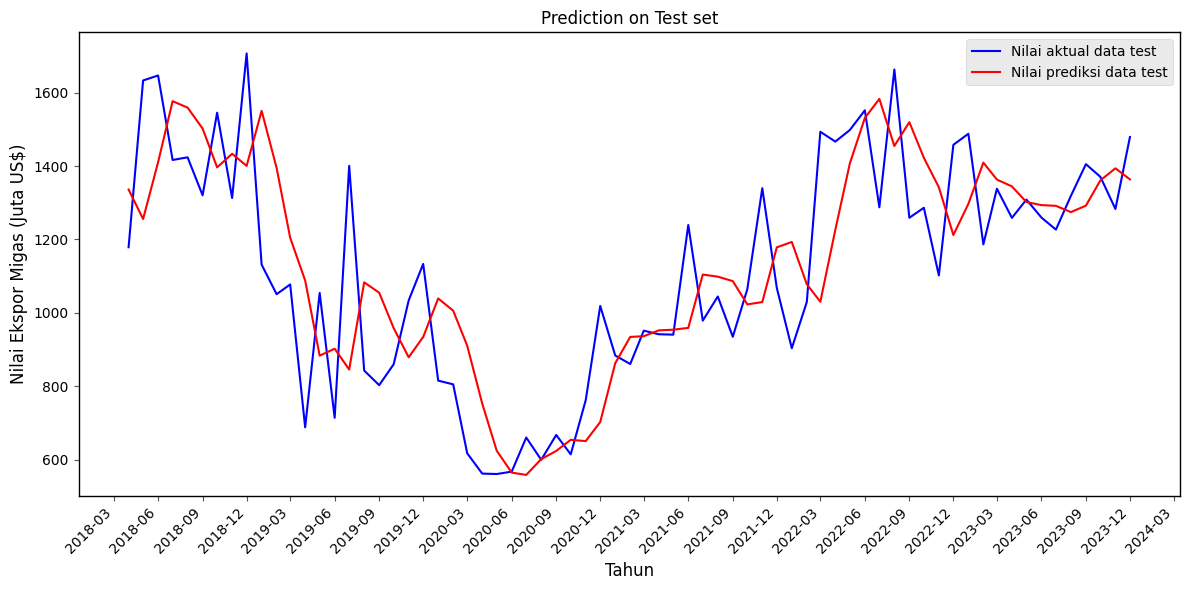

In [24]:
# Visualisasi prediksi vs aktual on test data
plt.figure(figsize=(12,6))
plt.title('Prediction on Test set', fontsize=12)
plt.xlabel('Tahun', fontsize=12, color='black')
plt.ylabel('Nilai Ekspor Migas (Juta US$)', fontsize=12, color='black')
plt.plot(date_test, y_test_actual, label='Nilai aktual data test', color='blue')
plt.plot(date_test, test_predictions, label='Nilai prediksi data test', color='red')

# Mengatur format tanggal
plt.gca().xaxis.set_major_locator(mdates.MonthLocator(interval=3))
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))

# Rotate dates for better visibility
plt.xticks(rotation=45)  # Memutar label x-axis agar lebih mudah dibaca
plt.legend(fontsize=10)
plt.xticks(rotation=45, ha='right', color='black')
plt.yticks(color='black')

# Mengatur latar belakang putih dan menghapus grid
plt.gca().set_facecolor('white')
plt.grid(False)

# Mengatur garis tepi
for spine in plt.gca().spines.values():
    spine.set_edgecolor('black')

plt.tight_layout()
plt.show()

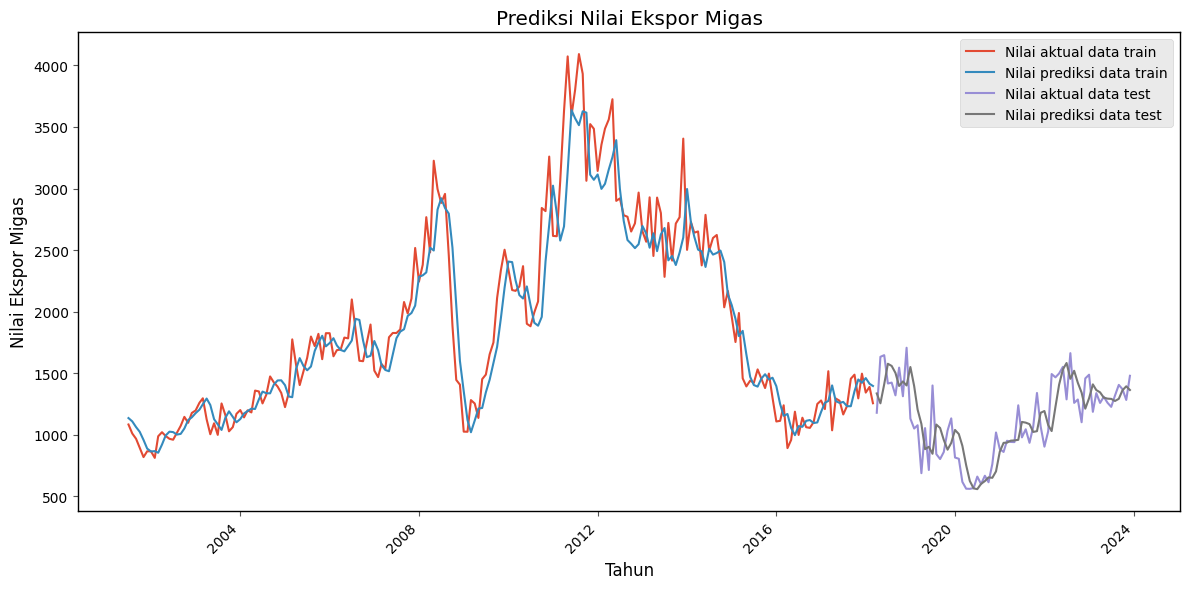

In [25]:
# Plot results
plt.figure(figsize=(12,6))
plt.plot(date_train, y_train_actual, label='Nilai aktual data train')
plt.plot(date_train, train_predictions, label='Nilai prediksi data train')
plt.plot(date_test, y_test_actual, label='Nilai aktual data test')
plt.plot(date_test, test_predictions, label='Nilai prediksi data test')
plt.title('Prediksi Nilai Ekspor Migas')
plt.xlabel('Tahun', color='black')
plt.ylabel('Nilai Ekspor Migas', color='black')
plt.legend(fontsize=10)
plt.legend()
plt.xticks(rotation=45, ha='right', color='black')
plt.yticks(color='black')
plt.legend(fontsize=10)

# Mengatur latar belakang putih dan menghapus grid
plt.gca().set_facecolor('white')
plt.grid(False)

# Mengatur garis tepi
for spine in plt.gca().spines.values():
    spine.set_edgecolor('black')

plt.tight_layout()
plt.show()

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 122ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 113ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step
      Tanggal  Nilai Ekspor Migas (Peramalan)
0  2024-01-01                     1416.038696
1  2024-02-01                     1433.616089
2  2024-03-01                     1449.460449
3  2024-04-01                     1463.382812
4  2024-05-01                     1472.790405
5  2024-06-01                     1478.147705
6  2024-07-01                     1489.770264
7  2024-08-01                     1497.601685
8  2024-09-01                     1505.305908
9  2024-10-01                     1512.899658
10 2024-11-01                     15

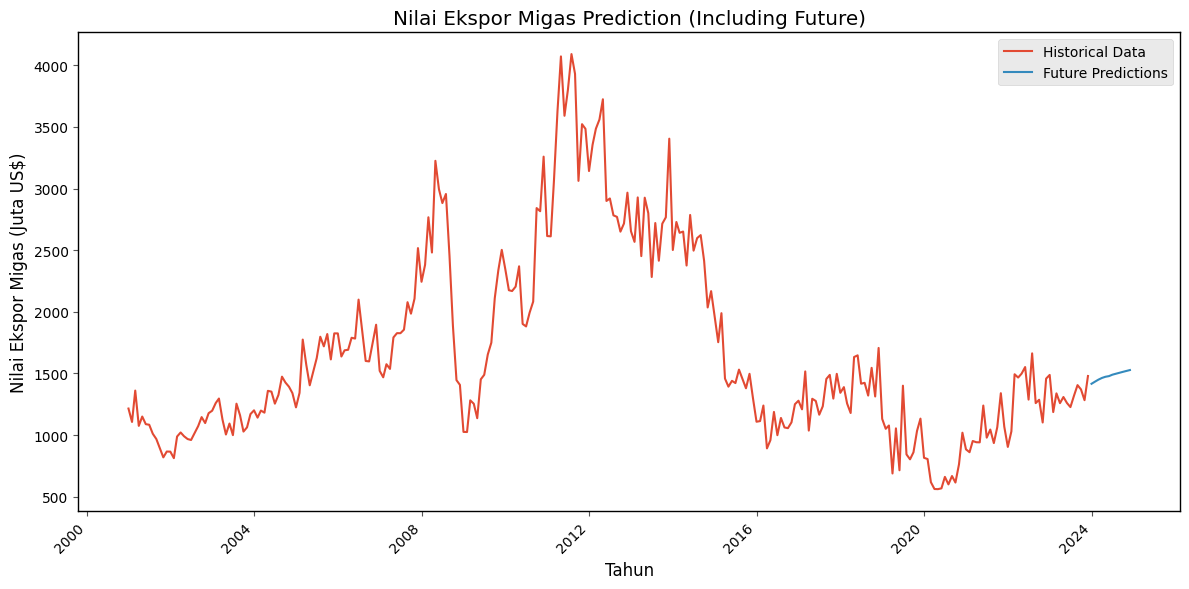

In [26]:
scaled_dt = scaler.fit_transform(dataset)

# Fungsi untuk melakukan peramalan
def forecast_future(model, last_data, periods, scaler):
    future_predictions = []
    current_batch = last_data

    for _ in range(periods):
        # Prediksi satu langkah ke depan
        current_pred = model.predict(current_batch)
        future_predictions.append(current_pred[0])

        # Update batch untuk prediksi berikutnya
        current_batch = np.roll(current_batch, -1, axis=1)
        current_batch[0, -1, 0] = current_pred[0]

    # Inverse transform hasil peramalan
    future_predictions = np.array(future_predictions).reshape(-1, 1)
    return scaler.inverse_transform(future_predictions)

# Ambil data terakhir untuk input peramalan
last_known_data = scaled_dt[-time_steps:]
last_known_data = last_known_data.reshape((1, time_steps, 1))

# Lakukan peramalan untuk 12 periode ke depan
future_periods = 12
future_predictions = forecast_future(model, last_known_data, future_periods, scaler)

# Buat tanggal untuk hasil peramalan
last_date = df['Tanggal'].iloc[-1]
future_dates = pd.date_range(start=last_date + pd.Timedelta(days=30), periods=future_periods, freq='MS')

# Buat DataFrame untuk hasil peramalan
forecast_df = pd.DataFrame({
    'Tanggal': future_dates,
    'Nilai Ekspor Migas (Peramalan)': future_predictions.flatten()
})

print(forecast_df)

# Plot future predictions
plt.figure(figsize=(12,6))
plt.plot(df['Tanggal'], df['Nilai Ekspor Migas'], label='Historical Data')
plt.plot(future_dates, future_predictions, label='Future Predictions')
plt.title('Nilai Ekspor Migas Prediction (Including Future)')
plt.xlabel('Tahun', fontsize=12, color='black')
plt.ylabel('Nilai Ekspor Migas (Juta US$)', fontsize=12, color='black')
plt.xticks(rotation=45, ha='right', color='black')
plt.yticks(color='black')
plt.legend(fontsize=10)

# Mengatur latar belakang putih dan menghapus grid
plt.gca().set_facecolor('white')
plt.grid(False)

# Mengatur garis tepi
for spine in plt.gca().spines.values():
    spine.set_edgecolor('black')

plt.tight_layout()

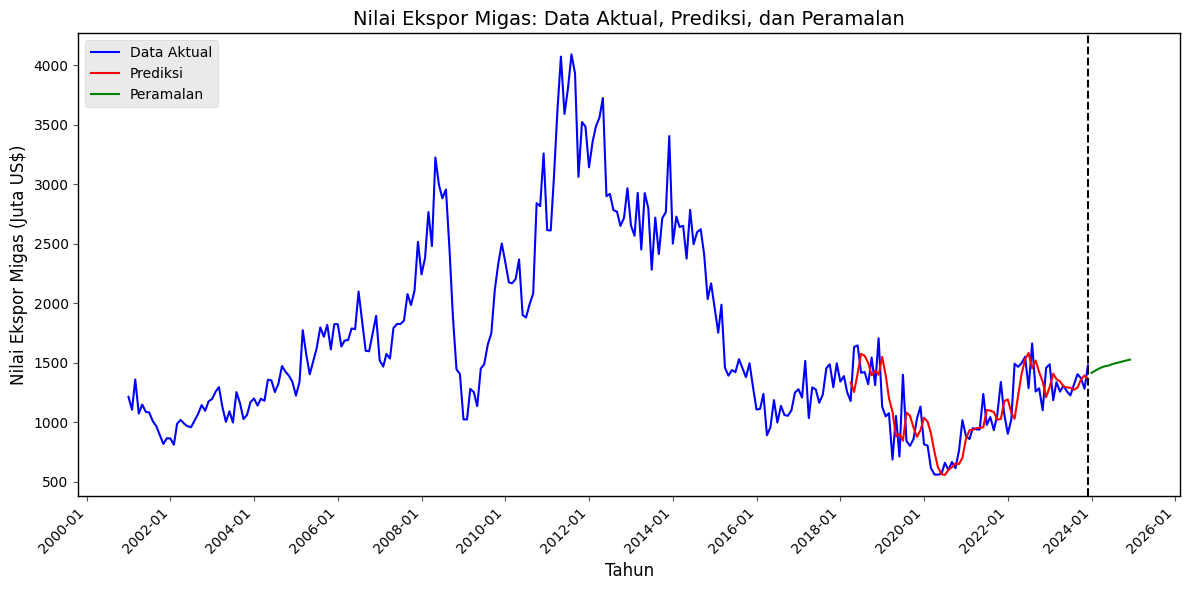

In [27]:
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import pandas as pd
import numpy as np

# Mengubah future_dates menjadi Series
future_dates_series = pd.Series(future_dates)

# Menggabungkan data aktual, prediksi data uji, dan hasil peramalan
all_dates = pd.concat([df['Tanggal'], future_dates_series])
all_actual = pd.concat([df['Nilai Ekspor Migas'], pd.Series([np.nan] * len(future_dates))])
all_predictions = np.concatenate([np.array([np.nan] * (len(df) - len(test_predictions))),
                                  test_predictions.flatten(),
                                  future_predictions.flatten()])

# Membuat plot
plt.figure(figsize=(12, 6))
plt.plot(all_dates, all_actual, label='Data Aktual', color='blue')

# Garis prediksi
plt.plot(all_dates[-len(test_predictions)-len(future_predictions):-len(future_predictions)],
         all_predictions[-len(test_predictions)-len(future_predictions):-len(future_predictions)],
         label='Prediksi', color='red')

# Garis peramalan
plt.plot(all_dates[-len(future_predictions):],
         all_predictions[-len(future_predictions):],
         label='Peramalan', color='green')

# Menambahkan garis vertikal untuk memisahkan data uji dan peramalan
split_date = df['Tanggal'].iloc[-1]
plt.axvline(x=split_date, color='black', linestyle='--')

plt.title('Nilai Ekspor Migas: Data Aktual, Prediksi, dan Peramalan', fontsize=14)
plt.xlabel('Tahun', fontsize=12, color='black')
plt.ylabel('Nilai Ekspor Migas (Juta US$)', fontsize=12, color='black')

# Mengatur format tanggal pada sumbu x
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))
plt.gca().xaxis.set_major_locator(mdates.YearLocator(base=2))

plt.xticks(rotation=45, ha='right', color='black')
plt.yticks(color='black')
plt.legend(fontsize=10)

# Mengatur latar belakang putih dan menghapus grid
plt.gca().set_facecolor('white')
plt.grid(False)

# Mengatur garis tepi
for spine in plt.gca().spines.values():
    spine.set_edgecolor('black')

plt.tight_layout()
plt.show()

In [28]:
!pip install openpyxl

In [29]:
forecast_df.to_excel('forecast_75:25_h1t6.xlsx', index=False)
from google.colab import files
files.download('forecast_75:25_h1t6.xlsx')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [30]:
import numpy as np
import pandas as pd

# Konversi y_train_actual, train_predictions, y_test_actual, dan test_predictions ke array satu dimensi
y_train_actual = np.array(y_train_actual).flatten()
train_predictions = np.array(train_predictions).flatten()
y_test_actual = np.array(y_test_actual).flatten()
test_predictions = np.array(test_predictions).flatten()

# Buat DataFrame untuk nilai aktual dan prediksi data train
# Membuat DataFrame hasil untuk training dan testing
train_df = pd.DataFrame({
    'Tanggal': date_train.reset_index(drop=True),
    'Data Aktual': y_train_actual,
    'Data Prediksi': train_predictions
})

# Buat DataFrame untuk nilai aktual dan prediksi data test
test_df = pd.DataFrame({
    'Tanggal': date_test.reset_index(drop=True),
    'Data Aktual': y_test_actual,
    'Data Prediksi': test_predictions
})

# Gabungkan train_df dan test_df menjadi satu DataFrame
prediksi_df = pd.concat([train_df, test_df])

# Simpan DataFrame ke dalam file Excel
prediksi_df.to_excel('prediksi_75:25_h1t6.xlsx', index=False)

# Jika Anda menggunakan Google Colab, Anda dapat mengunduh file Excel
from google.colab import files
files.download('prediksi_75:25_h1t6.xlsx')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>